In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:


def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [5]:
#from google.colab import drive

#drive.mount('/content/drive')
#path =path = '/content/drive/MyDrive/nmchr_lab/Subjects/inclined/new/right_based/'


In [6]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\SKS\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [7]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
#file_name = ['TH_4_I.xls', 'TH_2_I.xls', 'TH_3_I.xls']

# Subj TH:
#file_name = ['TH_4_I_r.xlsx', 'TH_2_I_r.xlsx', 'TH_3_I_r.xlsx']

# Subj JJ:
#file_name = ['JJ_4_I.xlsx', 'JJ_6_I.xlsx', 'JJ_7_I.xlsx']
#file_name = ['JJ_4_I_r.xlsx', 'JJ_6_I_r.xlsx', 'JJ_7_I_r.xlsx']

# Subj SD:
#file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

# Subj PK:
#file_name = ['PK_0_I_r.xls', 'PK_5_I_r.xls', 'PK_2_I_r.xls', 'PK_3_I_r.xls']

# Subj SKS:
file_name = ['SKS_0_I_r.xls', 'SKS_4_I_r.xls', 'SKS_2_I_r.xls', 'SKS_3_I_r.xls', 'SKS_5_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [8]:
file_name

['SKS_0_I_r.xls',
 'SKS_4_I_r.xls',
 'SKS_2_I_r.xls',
 'SKS_3_I_r.xls',
 'SKS_5_I_r.xls']

In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295263 entries, 0 to 295262
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      295263 non-null  float64
 1   l_ph_ank      295263 non-null  float64
 2   l_ph_fo       295263 non-null  float64
 3   r_ph_hip      295263 non-null  float64
 4   r_ph_ank      295263 non-null  float64
 5   r_ph_fo       295263 non-null  float64
 6   n_lgrf        295263 non-null  float64
 7   n_r_grf       295263 non-null  float64
 8   n_lcop        295263 non-null  float64
 9   n_rcop        295263 non-null  float64
 10  perc_new      295263 non-null  float64
 11  st_sw_phase   295263 non-null  int64  
 12  strike_frame  295263 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 29.3 MB


In [11]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table


,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.611116,0.735992,0.801771,0.966419,0.834757,0.728971,0.903571,0.038524,0.160310,-0.000650,0.000000,0,1
1,0.588054,0.735673,0.793695,0.960519,0.825309,0.727426,0.893552,0.055531,0.160213,-0.000564,0.467290,0,2
2,0.559142,0.735283,0.787223,0.954390,0.817850,0.725650,0.880142,0.075193,0.160077,-0.000441,0.934579,0,3
3,0.524418,0.734824,0.781910,0.948075,0.811864,0.723608,0.863104,0.097143,0.159880,-0.000275,1.401869,0,4
4,0.485948,0.734301,0.777454,0.941622,0.806997,0.721252,0.842289,0.121050,0.159584,-0.000060,1.869159,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293648,0.683425,0.730857,0.816422,0.007210,0.074280,0.700315,0.828443,0.000000,0.156199,-0.000287,97.196262,1,209
293649,0.676968,0.731268,0.804203,0.006879,0.022577,0.701820,0.831050,0.000000,0.156035,0.000187,97.663551,1,210
293650,0.669212,0.731533,0.794925,0.006266,0.967541,0.702717,0.832084,0.000000,0.155758,0.000773,98.130841,1,211
293651,0.659730,0.731668,0.787663,0.005310,0.920383,0.703061,0.831264,0.000000,0.155353,0.001484,98.598131,1,212


In [12]:
## ------ Left Leg -------

## Hip, COP
drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_rcop", "r_ph_hip", "r_ph_fo", "l_ph_fo"]
## Hip, Foot, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_rcop", "r_ph_hip", "r_ph_fo"]

## ------ Right Leg ------

## Hip, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_lcop", "l_ph_hip", "l_ph_fo", "r_ph_fo"]
## Hip, Foot, COP
#rop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_lcop", "l_ph_hip", "l_ph_fo"]

## ------ Both Leg ------

## Hip, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "l_ph_fo", "r_ph_fo"]
## Hip, Foot, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase"]

In [13]:
source_table = source_table.drop(drop_list, axis = 1)#,'l_ph_hip','l_ph_fo','n_lcop'], axis = 1)
source_table

,l_ph_hip,n_lcop,perc_new,strike_frame
0,0.611116,0.160310,0.000000,1
1,0.588054,0.160213,0.467290,2
2,0.559142,0.160077,0.934579,3
3,0.524418,0.159880,1.401869,4
4,0.485948,0.159584,1.869159,5
...,...,...,...,...
293648,0.683425,0.156199,97.196262,209
293649,0.676968,0.156035,97.663551,210
293650,0.669212,0.155758,98.130841,211
293651,0.659730,0.155353,98.598131,212


In [15]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [16]:
data_y = y.values.reshape(-1,2)

In [17]:
type(data_y)

numpy.ndarray

In [18]:


#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [19]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(220228, 10, 3)
(220228, 2)
(73403, 10, 3)
(73403, 2)


In [20]:
train_x.shape

(220228, 10, 3)

In [21]:


n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(7339, 10, 3)
(7339, 2)


In [22]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        print(x.shape)
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [23]:
import tensorflow as tf
lr = 0.001
epochs = 30
batch = 128
n_features=train_x.shape[2]
seq_len = train_x.shape[1]
x=Input(shape=(seq_len, train_x.shape[2]))


l1=tf.keras.layers.AveragePooling1D(
    pool_size=2,
    strides=1)(x)
att1 = attention()(x)
rep_layer = L.RepeatVector((seq_len))(att1)

l2=L.Dense(n_features)(x)
print(l1.shape)
print(l2.shape)

inp=tf.concat([l1,rep_layer,l2],1)
print(inp.shape)
inp = L.MaxPooling1D(pool_size=2,strides=1)(inp)

# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(inp)
# attn_layer1 = attention()(LSTM_layer2)
tmp_layer = L.Flatten()(LSTM_layer2)
lin_layer1= L.Dense(32)(tmp_layer)
lin_layer2 = L.Dense(2)(lin_layer1)
# rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
# LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
# LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
# lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer2)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

(None, 10, 3)
(None, 9, 3)
(None, 10, 3)
(None, 29, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 attention (attention)          (None, 3)            13          ['input_1[0][0]']                
                                                                                                  
 average_pooling1d (AveragePool  (None, 9, 3)        0           ['input_1[0][0]']                
 ing1D)                                                                                           
                                                                                                  
 repeat_vector (RepeatVector)   (None, 

In [24]:
import tensorflow as tf
lr = 0.001
epochs = 30
batch = 128
n_features=train_x.shape[2]
seq_len = train_x.shape[1]
x=Input(shape=(seq_len, train_x.shape[2]))


l1=tf.keras.layers.AveragePooling1D(
    pool_size=2,
    strides=None)(x)
att1 = attention()(x)
rep_layer = L.RepeatVector((seq_len))(att1)

l2=L.Dense(n_features)(x)
print(l1.shape)
print(l2.shape)

inp=tf.concat([l1,rep_layer,l2],1)
print(inp.shape)
# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(inp)
# attn_layer1 = attention()(LSTM_layer2)
tmp_layer = L.Flatten()(LSTM_layer2)
lin_layer1= L.Dense(32)(tmp_layer)
lin_layer2 = L.Dense(2)(lin_layer1)
# rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
# LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
# LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
# lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer2)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

(None, 10, 3)
(None, 5, 3)
(None, 10, 3)
(None, 25, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 attention_1 (attention)        (None, 3)            13          ['input_2[0][0]']                
                                                                                                  
 average_pooling1d_1 (AveragePo  (None, 5, 3)        0           ['input_2[0][0]']                
 oling1D)                                                                                         
                                                                                                  
 repeat_vector_1 (RepeatVector)  (Non

In [25]:
model_history = model.fit( train_x, train_y, epochs=epochs, batch_size=batch,  verbose=1)

Epoch 1/30
(None, 10, 3)
(None, 10, 3)
1721/1721 [==============================] - 22s 12ms/step - loss: 0.0222
Epoch 2/30
1721/1721 [==============================] - 21s 12ms/step - loss: 0.0087
Epoch 3/30
1721/1721 [==============================] - 20s 12ms/step - loss: 0.0077
Epoch 4/30
1721/1721 [==============================] - 20s 12ms/step - loss: 0.0070
Epoch 5/30
1721/1721 [==============================] - 21s 12ms/step - loss: 0.0066
Epoch 6/30
1721/1721 [==============================] - 20s 12ms/step - loss: 0.0065
Epoch 7/30
1721/1721 [==============================] - 21s 12ms/step - loss: 0.0064
Epoch 8/30
1721/1721 [==============================] - 20s 12ms/step - loss: 0.0062
Epoch 9/30
1721/1721 [==============================] - 21s 12ms/step - loss: 0.0062
Epoch 10/30
1721/1721 [==============================] - 20s 12ms/step - loss: 0.0061
Epoch 11/30
1721/1721 [==============================] - 20s 12ms/step - loss: 0.0061
Epoch 12/30
1721/1721 [============

In [26]:
#model.save(path+"cnn_new_model_all_sub_2_leg_")

In [27]:
#model = tf.keras.models.load_model(path+"cnn_new_model_sd_sks_th")

In [28]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [29]:
# trainPredict = model.predict(train_x)
testPredict = model.predict(validation_x)

(None, 10, 3)
2294/2294 [==============================] - 13s 6ms/step


In [30]:

testPredict.shape

(73403, 2)

In [31]:
from sklearn.metrics import mean_squared_error

# trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
# print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.07 RMSE


In [32]:
v = X_test[11:]
v.shape

(73403, 3)

In [33]:
x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  
  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) : 
    pred[iter] = pred[iter] - 100  
    if abs(pred[iter]) >= 5:
      pred[iter] = 0 
  

  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]
    if abs(pred[iter]) >= 5:
        pred[iter] = 100


In [34]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [35]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)): # or (actual[iter]>98) or(actual[iter]<3):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

41994
73403
Precision  1 :  57.21019576856532
60286
73403
Precision  2 :  82.13015816792229
68325
73403
Precision  3 :  93.0820266201654
71632
73403
Precision  4 :  97.5872920725311
72748
73403
Precision  5 :  99.10766589921393


In [36]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)



Predicting Percentage RMSE:  1.575943582546826


In [37]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

73403
73403
1.5759435825468235


43675
73403


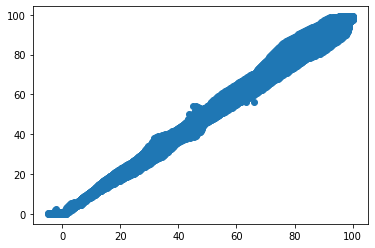

In [38]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<5 or actual[iter]>95:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

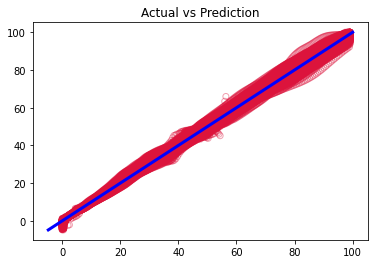

In [39]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [40]:
tf.keras.utils.plot_model(model, 'model_new.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
file_name = ['PK_0_I_r.xls', 'PK_2_I_r.xls', 'PK_3_I_r.xls','PK_5_I_r.xls']


for i in range (len(file_name)):
    file_list.append(pd.read_excel(path+ file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)

cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
source_table = source_table.drop(["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank"], axis = 1)#,'l_ph_hip','l_ph_fo','n_lcop'], axis = 1)

x = source_table
x = x.drop(['perc'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc')
y = source_table[["X","Y"]]
y

data_x = x_scaled
data_y = y.values.reshape(-1,2)
look_back=10
fore_cast=1
val_new_x, val_new_y = convert_data(data_x, data_y, look_back, fore_cast)


NameError: name 'path' is not defined

In [ ]:
testPredict = model.predict(val_new_x)

35853/35853 [==============================] - 236s 7ms/step


In [ ]:
v = val_new_x[11:]
v.shape

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  # pred1=pd.DataFrame(pred).sort_index().reset_index()

actual = np.zeros((len(val_new_y),1))

for iter in range(len(val_new_x)):
  x =val_new_y[iter][0]
  y =val_new_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))



correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

671947
1147286
Precision  1 :  58.56839532601287
872502
1147286
Precision  2 :  76.04921527849203
939596
1147286
Precision  3 :  81.89727757507718
975049
1147286
Precision  4 :  84.9874399234367
997114
1147286
Precision  5 :  86.91067440899654


In [ ]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

Predicting Percentage RMSE:  12.209285477150495
1135419
1147286
7.128382042631977


<ipython-input-40-21bf04cfed5a>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Text(0.5, 1.0, 'Actual vs Prediction')

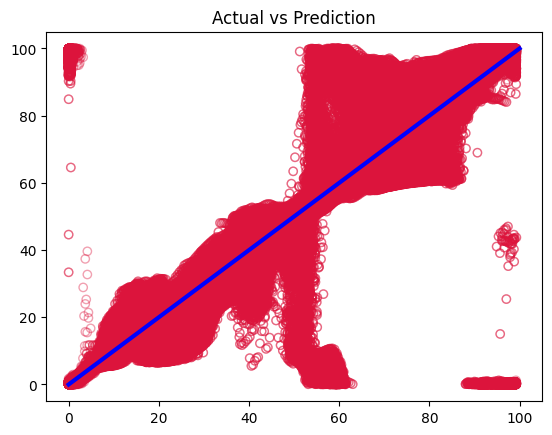

In [ ]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')